<a href="https://colab.research.google.com/github/AbdulHakkam/SDGP/blob/ML-Model/Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2 as cv
import pandas as pd
import sklearn.metrics as metrics
from tensorflow import keras

import numpy as np

!pip install livelossplot
from livelossplot import PlotLossesKeras

from tensorflow.keras.preprocessing.image import ImageDataGenerator


(ds_train,ds_test),info = tfds.load('StanfordDogs', split=["train","test"], with_info=True,as_supervised=True)  #retreiving dataset
print(info)






Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteH37PXJ/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteH37PXJ/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }

In [ ]:
def preprocess(image,label):                                                   #preprocess dataset before training by converting type and resizing it to 224,224,3

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (244,244), method='nearest')
  
    label = tf.one_hot(label,120)

    return image, label
def prepare(dataset, batch_size=None):                                         #prepares the dataset for training by preprocessing,shuffling and then prefetching the data                       
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds
  


  



ds_train = prepare(ds_train,batch_size=32)
ds_test =prepare(ds_test,batch_size=32)



IMG_SHAPE=(244,244,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(120, activation='softmax')
])


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
def augment_using_ops(images, labels):
	
	images = tf.image.random_flip_left_right(images)
	images = tf.image.random_flip_up_down(images)
	images = tf.image.rot90(images)
	
	return (images, labels)
 
 




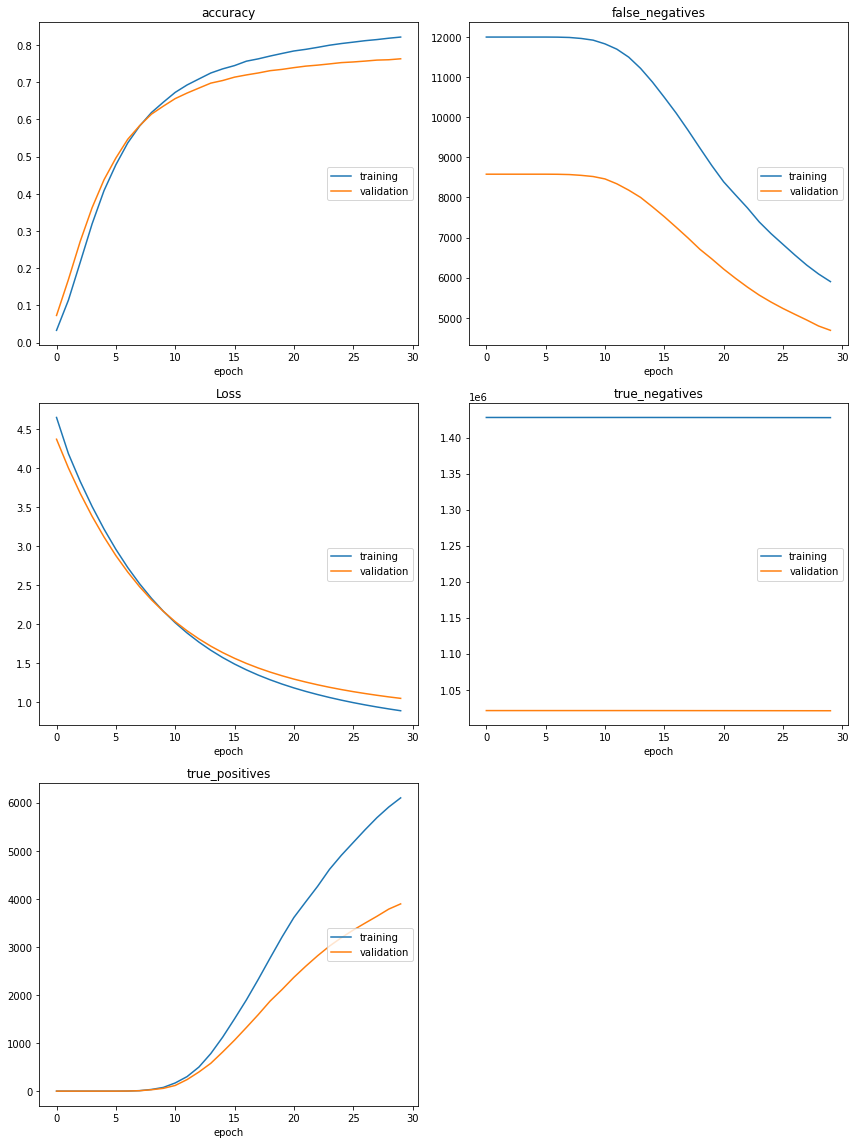

accuracy
	training         	 (min:    0.033, max:    0.821, cur:    0.821)
	validation       	 (min:    0.073, max:    0.763, cur:    0.763)
false_negatives
	training         	 (min: 5901.000, max: 12000.000, cur: 5901.000)
	validation       	 (min: 4686.000, max: 8580.000, cur: 4686.000)
Loss
	training         	 (min:    0.888, max:    4.646, cur:    0.888)
	validation       	 (min:    1.046, max:    4.367, cur:    1.046)
true_negatives
	training         	 (min: 1427771.000, max: 1428000.000, cur: 1427771.000)
	validation       	 (min: 1020800.000, max: 1021020.000, cur: 1020800.000)
true_positives
	training         	 (min:    0.000, max: 6099.000, cur: 6099.000)
	validation       	 (min:    0.000, max: 3894.000, cur: 3894.000)
375/375 [==============================] - 98s 252ms/step - loss: 0.8877 - accuracy: 0.8210 - true_negatives: 1427771.0000 - false_negatives: 5901.0000 - true_positives: 6099.0000 - val_loss: 1.0463 - val_accuracy: 0.7626 - val_true_negatives: 1020800.0000 - va

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.TruePositives()]
              )

history = model.fit(ds_train,epochs=30,validation_data=ds_test,callbacks=[PlotLossesKeras()])

In [ ]:
model.save('content/model.h5')

In [7]:
new_model = tf.keras.models.load_model('content/model.h5')


new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
from keras.preprocessing.image import load_img
from torchvision.transforms import ToTensor
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from keras.preprocessing.image import img_to_array

In [53]:
img = load_img('test1.jpg')

In [67]:
def img_proceess(image):
    image = tf.image.resize(image, [244, 244,3])
    image = image / 255.0
    image = image.reshape(0,244, 244, 3)
    return image

In [69]:
img = load_img('test1.jpg')
image = img_process(image)


In [70]:
model.predict(image)

ValueError: ignored